In [2]:
import tensorflow as  tf 

tf.config.list_physical_devices('GPU')

2023-12-07 16:45:05.504097: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 16:45:05.504131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 16:45:05.504945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 16:45:05.580015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 16:45:06.606384: W tensorflow/compiler/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-12-07 16:45:07.731186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 16:45:07.731417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
import numpy as np
from scipy.signal import spectrogram
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import os
from concurrent.futures import ThreadPoolExecutor

def ProcessData(data,n_steps,individual,stride):

    def getXYdata(data):
        from sklearn.preprocessing import LabelEncoder
        yData = []
        X = data.get_data()
        contador = 0
        start_t = data.annotations.onset
        for i in range(0,X.shape[1]):
            time = i/160
            if contador < data.annotations.description.shape[0]:
                if time >= start_t[contador]:
                    contador = contador + 1
            yData.append(data.annotations.description[contador-1])
        yData = np.array(yData)
        le = LabelEncoder()
        le.fit(yData)
        yData = le.transform(yData)
        return X.T,yData

    Xdata,yData = getXYdata(data)
    features = 64  


    def splitTimeSeries(Xdata, ydata, n_steps,stride):
        X = np.zeros(((Xdata.shape[0] - n_steps)//stride, n_steps, features))
        y = np.zeros(((Xdata.shape[0] - n_steps)//stride, 1))


        for i in range(n_steps, len(X) - 1,stride):
            X[i - n_steps] = Xdata[i - n_steps:i]
            y[i - n_steps] = ydata[i+1]

        return X, y
    
    return splitTimeSeries(Xdata,yData,n_steps,stride)

In [4]:
import mne

import numpy as np




#gathering all tests from a single individual
basePath = "physionet.org/files/eegmmidb/1.0.0/"
individual = 2
first = True
for exam in range(3,6): # 3,14 is the interval for the valid data
    file = basePath+f"S{str(individual).zfill(3)}/S{str(individual).zfill(3)}R{str(exam).zfill(2)}.edf"
    data = mne.io.read_raw_edf(file)
    n_steps = 700
    stride = 10
    if first:
        X,y = ProcessData(data,n_steps,individual,stride)
        first = False
    else:
        X1,y1 = ProcessData(data,n_steps,individual,stride)
        X = np.concatenate((X,X1),axis=0)
        y = np.concatenate((y,y1),axis=0)

Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S002/S002R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [5]:
X.shape

(5694, 700, 64)

In [6]:


index_80 = int(Xdata.shape[0]*0.8)

Xtrain,ytrain = Xdata[0:index_80],ydata[0:index_80]

Xval,yval = Xdata[index_80:],ydata[index_80:]
Xdata.shape

NameError: name 'Xdata' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

features = 64

model = Sequential()
model.add(LSTM(units=64, activation="tanh", return_sequences=False, input_shape=(None, features)))
model.add(Dense(units=3, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 33219 (129.76 KB)
Trainable params: 33219 (129.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint

# # Define a checkpoint callback
# checkpoint_path = "model_checkpoint.tf"
# checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

# Train the model with the checkpoint callback
result = model.fit(Xtrain, ytrain, epochs=100, batch_size=32, verbose=2,validation_data=(Xval, yval))

Epoch 1/100


2023-11-27 23:17:20.899070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-27 23:17:21.062437: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f05b0001c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 23:17:21.062471: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-11-27 23:17:21.079837: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 23:17:21.199627: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


492/492 - 5s - loss: 1.0439 - accuracy: 0.4989 - val_loss: 1.0428 - val_accuracy: 0.5071 - 5s/epoch - 10ms/step
Epoch 2/100
492/492 - 1s - loss: 1.0414 - accuracy: 0.4992 - val_loss: 1.0350 - val_accuracy: 0.5071 - 1s/epoch - 3ms/step
Epoch 3/100
492/492 - 1s - loss: 1.0406 - accuracy: 0.4992 - val_loss: 1.0428 - val_accuracy: 0.5071 - 1s/epoch - 3ms/step
Epoch 4/100
492/492 - 1s - loss: 1.0412 - accuracy: 0.4992 - val_loss: 1.0297 - val_accuracy: 0.5071 - 1s/epoch - 2ms/step
Epoch 5/100
492/492 - 1s - loss: 1.0409 - accuracy: 0.4992 - val_loss: 1.0380 - val_accuracy: 0.5071 - 1s/epoch - 2ms/step
Epoch 6/100
492/492 - 1s - loss: 1.0407 - accuracy: 0.4992 - val_loss: 1.0299 - val_accuracy: 0.5071 - 1s/epoch - 3ms/step
Epoch 7/100
492/492 - 1s - loss: 1.0408 - accuracy: 0.4992 - val_loss: 1.0341 - val_accuracy: 0.5071 - 1s/epoch - 3ms/step
Epoch 8/100
492/492 - 1s - loss: 1.0407 - accuracy: 0.4992 - val_loss: 1.0393 - val_accuracy: 0.5071 - 1s/epoch - 3ms/step
Epoch 9/100
492/492 - 1s - 

KeyboardInterrupt: 

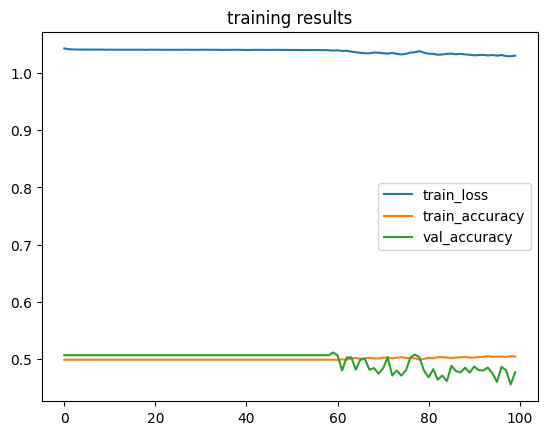

In [ ]:
plt.title("training results")
plt.plot(result.history['loss'], label='train_loss')

plt.plot(result.history['accuracy'], label='train_accuracy')
plt.plot(result.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()  

In [ ]:
ypred = model.predict(Xtrain)

492/492 [==============================] - 1s 1ms/step


In [ ]:
y2 = np.argmax(ypred, axis=1)

In [ ]:
y2.shape

(15720,)

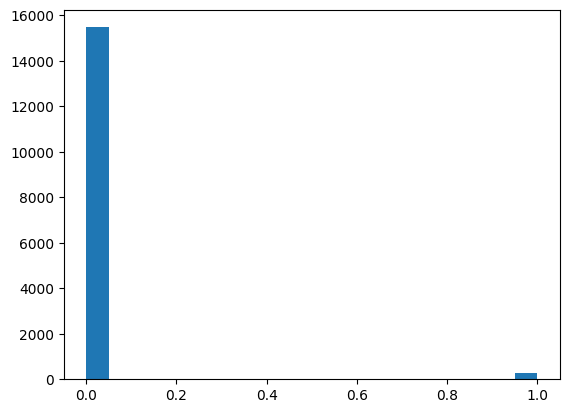

In [ ]:
plt.hist(y2, bins=20)
plt.show()